Hopfield Networks

https://towardsdatascience.com/hopfield-networks-neural-memory-machines-4c94be821073

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests, gzip, os, hashlib
import pygame

pygame 2.5.2 (SDL 2.28.3, Python 3.8.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Hopfield_Net: #network class
  def __init__(self,input):
    # patterns for network training / retrieval
    self.memory = np.array(input)
    # single vs. multiple memories
    if self.memory.size > 1:
      self.n = self.memory.shape[1]
    else:
      self.n = len(self.memory)
    # network construction
    self.state = np.random.randint(-2,2,(self.n,1)) # state vector
    self.weights = np.zeros((self.n,self.n)) # weights vector
    self.energies = [] # container for tracking of energy

  def network_learning(self): # learn the pattern / patterns
    self.weights = (1 / self.memory.shape[0]) * self.memory.T @ self.memory # hebbian learning
    np.fill_diagonal(self.weights, 0)

  def update_network_state(self,n_update): # update network
    for neuron in range(n_update): # update n neurons randomly
      self.rand_index = np.random.randint(0,self.n) # pick a random neuron in the state vector
      # Compute activation for randomly indexed neuron
      self.index_activation = np.dot(self.weights[self.rand_index,:], self.state) 
      # threshold function for binary state change
      if self.index_activation < 0: 
        self.state[self.rand_index] = -1
      else:
        self.state[self.rand_index] =  1

  def compute_energy(self): #compute energy
    self.energy = -0.5*np.dot(np.dot(self.state.T,self.weights),self.state)
    self.energies.append(self.energy)

In [3]:
#for MNIST fetch
#Fetch MNIST dataset from the ~SOURCE~
def fetch_MNIST(url):
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  
  return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

In [4]:
def MNIST_Hopfield(): 
    #test out the Hopfield_Network object on some MNIST data
    #fetch MNIST dataset for some random memory downloads
    
    #The first 16 (0x10) bytes of the MNIST dataset file contain the header information 
    X = fetch_MNIST("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1,784))
    
    #convert to binary
    X_binary = np.where(X>20, 1,-1)

    #Snag a memory from computer brain
    memories_list = np.array([X_binary[np.random.randint(len(X))]])
    
    #initialize Hopfield object
    H_Net = Hopfield_Net(memories_list)
    H_Net.network_learning()

    #Draw it all out, updating board each update iteration
    cellsize = 20
   
    pygame.init() #initialize pygame
    #set dimensions of board and cellsize -  28 X 28  ~ special display surface
    surface = pygame.display.set_mode((28*cellsize,28*cellsize)) 
    pygame.display.set_caption("   ")
    
    #kill pygame if user exits window
    Running = True
    #main animation loop
    while Running:
      for event in pygame.event.get():
        if event.type == pygame.QUIT:
          Running = False
          
          #plot weights matrix
          plt.figure("weights", figsize=(10,7))
          plt.imshow(H_Net.weights,cmap='RdPu') #
          plt.xlabel("Each row/column represents a neuron, each square a connection")
  
          plt.title("4096 Neurons - 16,777,216 unique connections",fontsize=15)
          plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

          #plot energies
          plt.figure("Energy",figsize=(10,7))
          x = np.arange(len(H_Net.energies))
          plt.scatter(x,np.array(H_Net.energies),s=1,color='red')
          plt.xlabel("Generation")
          plt.ylabel("Energy")
          plt.title("Network Energy over Successive Generations",fontsize=15)
          plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

          #quit pygame
          pygame.quit()
  
      cells = H_Net.state.reshape(28,28).T
      
      #fills surface with color
      surface.fill((211,211,211)) 
      
      #loop through network state array and update colors for each cell
      for r, c in np.ndindex(cells.shape): #iterates through all cells in cells matrix
        if cells[r,c] == -1:
          col = (135,206,250)
        elif cells[r,c] == 1:
          col = (0,0,128)
        else: 
          col = (255,140,0)
        pygame.draw.rect(surface, col, (r*cellsize, c*cellsize, cellsize, cellsize)) #draw new cell_               
      
      #update network state
      H_Net.update_network_state(16)
      H_Net.compute_energy()
      pygame.display.update() #updates display from new .draw in update function
      pygame.time.wait(50)

error: display Surface quit

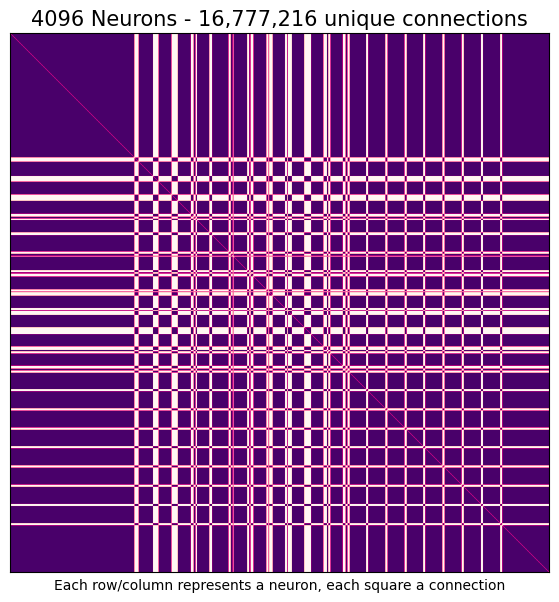

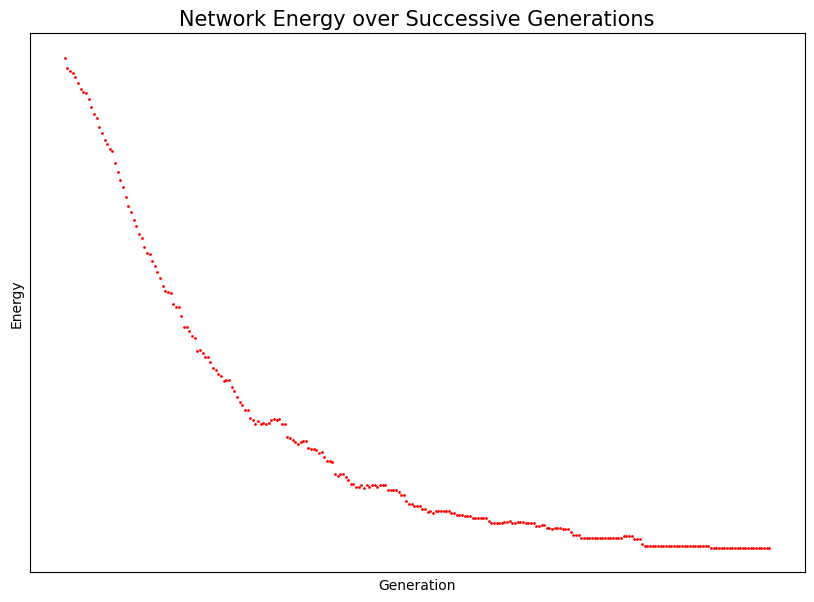

In [5]:
MNIST_Hopfield()
plt.show()